# Air Quality Analysis Ulm 2022

## Business Understanding

### Relevant Imports

In [1]:
import urllib
import pandas as pd
from pandas import json_normalize
from pandasql import sqldf
import json
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

### Extract data from API

In [2]:
# get HTTP Response from url
url = 'https://datenhub.ulm.de/ckan/api/3/action/datastore_search?resource_id=b49de35e-040c-4530-9208-eefadc97b610&limit=206725'  
response = urllib.request.urlopen(url)
assert response.code == 200

In [3]:
# convert HTTP Response to json
string = response.read().decode('utf-8')
response_dict = json.loads(string)
assert response_dict['success'] is True

In [4]:
# convert JSON object to dataframe
created_package = response_dict['result']
df = pd.DataFrame.from_dict(created_package['records'])

In [5]:
# remove \r\n from string conversion
df = df.replace({r'\r\n': ''}, regex=True)

## Data Understanding

#### Beschreibung der Daten

station: Beschreibung des Messortes<br>
schadstoff: Schadstoffe in der Luft <br>
zeit_utc: Zeitstempel am Ende der Messung<br>
wert: Messwert in µg/m³ <br>

Schadstoffe
- NO2: Stickstoffdioxid
- O3: Ozon
- PM2.5: Feinstaub mit einem Durchmesser kleiner als 2,5µm
- PM10: Feinstaub mit einem Durchmesser kleiner als 10µm<br>


## Data Preperation

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206725 entries, 0 to 206724
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   _id         206725 non-null  int64  
 1   station     206725 non-null  object 
 2   schadstoff  206725 non-null  object 
 3   zeit_utc    206725 non-null  object 
 4   wert        206725 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 7.9+ MB


In [7]:
df['zeit_utc'] = df['zeit_utc'].replace({r'T': ' '}, regex=True)
df

,_id,station,schadstoff,zeit_utc,wert
0,1,Ulm Trollingerweg 2,NO2,2020-11-13 01:00:00,33.0
1,2,Ulm Trollingerweg 2,O3,2020-11-13 01:00:00,0.0
2,3,Ulm Trollingerweg 2,PM10,2020-11-13 01:00:00,26.0
3,4,Ulm in der Wanne,PM10,2020-11-13 01:00:00,22.0
4,5,Ulm Trollingerweg 2,PM2.5,2020-11-13 01:00:00,15.0
...,...,...,...,...,...
206720,206721,Ulm in der Wanne,PM2.5,2022-08-11 15:00:00,8.0
206721,206722,Ulm in der Wanne,NO2,2022-08-11 16:00:00,34.0
206722,206723,Ulm in der Wanne,O3,2022-08-11 16:00:00,99.0
206723,206724,Ulm in der Wanne,PM10,2022-08-11 16:00:00,24.0


In [8]:
df['zeit_utc'] = pd.to_datetime(df['zeit_utc'])

In [9]:
# separate date and time values
df['date'] = [d.date() for d in df['zeit_utc']]
df['time'] = df['zeit_utc'].dt.strftime('%H')
df.drop('zeit_utc', axis=1, inplace=True)
df

,_id,station,schadstoff,wert,date,time
0,1,Ulm Trollingerweg 2,NO2,33.0,2020-11-13,01
1,2,Ulm Trollingerweg 2,O3,0.0,2020-11-13,01
2,3,Ulm Trollingerweg 2,PM10,26.0,2020-11-13,01
3,4,Ulm in der Wanne,PM10,22.0,2020-11-13,01
4,5,Ulm Trollingerweg 2,PM2.5,15.0,2020-11-13,01
...,...,...,...,...,...,...
206720,206721,Ulm in der Wanne,PM2.5,8.0,2022-08-11,15
206721,206722,Ulm in der Wanne,NO2,34.0,2022-08-11,16
206722,206723,Ulm in der Wanne,O3,99.0,2022-08-11,16
206723,206724,Ulm in der Wanne,PM10,24.0,2022-08-11,16


#### Prepare schadstoffe

In [10]:
df2 = df
df2['NO2'] = ""
df2['O3'] = ""
df2['PM10'] = ""
df2['PM2.5'] = ""
df2

,_id,station,schadstoff,wert,date,time,NO2,O3,PM10,PM2.5
0,1,Ulm Trollingerweg 2,NO2,33.0,2020-11-13,01,,,,
1,2,Ulm Trollingerweg 2,O3,0.0,2020-11-13,01,,,,
2,3,Ulm Trollingerweg 2,PM10,26.0,2020-11-13,01,,,,
3,4,Ulm in der Wanne,PM10,22.0,2020-11-13,01,,,,
4,5,Ulm Trollingerweg 2,PM2.5,15.0,2020-11-13,01,,,,
...,...,...,...,...,...,...,...,...,...,...
206720,206721,Ulm in der Wanne,PM2.5,8.0,2022-08-11,15,,,,
206721,206722,Ulm in der Wanne,NO2,34.0,2022-08-11,16,,,,
206722,206723,Ulm in der Wanne,O3,99.0,2022-08-11,16,,,,
206723,206724,Ulm in der Wanne,PM10,24.0,2022-08-11,16,,,,


In [11]:
df2['NO2'] = df.apply(lambda x: x['wert'] if x['schadstoff'] == 'NO2' else '', axis=1)
df2['O3'] = df.apply(lambda x: x['wert'] if x['schadstoff'] == 'O3' else '', axis=1)
df2['PM10'] = df.apply(lambda x: x['wert'] if x['schadstoff'] == 'PM10' else '', axis=1)
df2['PM2.5'] = df.apply(lambda x: x['wert'] if x['schadstoff'] == 'PM2.5' else '', axis=1)
df2

,_id,station,schadstoff,wert,date,time,NO2,O3,PM10,PM2.5
0,1,Ulm Trollingerweg 2,NO2,33.0,2020-11-13,01,33.0,,,
1,2,Ulm Trollingerweg 2,O3,0.0,2020-11-13,01,,0.0,,
2,3,Ulm Trollingerweg 2,PM10,26.0,2020-11-13,01,,,26.0,
3,4,Ulm in der Wanne,PM10,22.0,2020-11-13,01,,,22.0,
4,5,Ulm Trollingerweg 2,PM2.5,15.0,2020-11-13,01,,,,15.0
...,...,...,...,...,...,...,...,...,...,...
206720,206721,Ulm in der Wanne,PM2.5,8.0,2022-08-11,15,,,,8.0
206721,206722,Ulm in der Wanne,NO2,34.0,2022-08-11,16,34.0,,,
206722,206723,Ulm in der Wanne,O3,99.0,2022-08-11,16,,99.0,,
206723,206724,Ulm in der Wanne,PM10,24.0,2022-08-11,16,,,24.0,


In [12]:
df2.drop('schadstoff', axis=1, inplace=True)
df2.drop('wert', axis=1, inplace=True)

In [13]:
query = """
SELECT _id, station, date, time, SUM(NO2) as NO2, SUM(O3) as O3, SUM(PM10) as PM10, SUM("PM2.5") as "PM2.5"
FROM df
GROUP BY station, date, time
ORDER BY _id ASC
"""
df3 = sqldf(query, globals())
df3

,_id,station,date,time,NO2,O3,PM10,PM2.5
0,1,Ulm Trollingerweg 2,2020-11-13,01,33.0,0.0,26.0,15.0
1,4,Ulm in der Wanne,2020-11-13,01,23.0,0.0,22.0,9.0
2,8,Ulm Maehringer Weg 95,2020-11-13,01,23.0,2.0,20.0,14.0
3,11,Ulm Spielplatz Sonnenhalde,2020-11-13,01,24.0,0.0,28.0,14.0
4,15,Ulm Spielplatz Eselsberg Fort,2020-11-13,01,24.0,0.0,20.0,15.0
...,...,...,...,...,...,...,...,...
51492,206706,Ulm in der Wanne,2022-08-11,12,31.0,91.0,18.0,8.0
51493,206710,Ulm in der Wanne,2022-08-11,13,31.0,93.0,19.0,8.0
51494,206714,Ulm in der Wanne,2022-08-11,14,36.0,98.0,22.0,8.0
51495,206718,Ulm in der Wanne,2022-08-11,15,36.0,100.0,22.0,8.0


## Modelling

In [14]:
query = "SELECT DISTINCT station FROM df"
sqldf(query, globals())

,station
0,Ulm Trollingerweg 2
1,Ulm in der Wanne
2,Ulm Maehringer Weg 95
3,Ulm Spielplatz Sonnenhalde
4,Ulm Spielplatz Eselsberg Fort


In [15]:
print("Date range:")
query = "SELECT MIN(date), MAX(date) FROM df"
sqldf(query, globals())

Date range:


,MIN(date),MAX(date)
0,2020-11-13,2022-08-11


In [16]:
df3.describe()

,_id,NO2,O3,PM10,PM2.5
count,51497.000000,51497.000000,51497.000000,51497.000000,51497.000000
mean,102484.370604,22.794668,34.036934,16.890052,10.480533
std,59605.540627,9.939153,23.332659,10.585981,8.125877
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,50830.000000,15.000000,16.000000,10.000000,5.000000
50%,102139.000000,20.000000,32.000000,15.000000,9.000000
75%,155196.000000,28.000000,48.000000,22.000000,14.000000
max,206722.000000,122.000000,246.000000,113.000000,93.000000


In [17]:
query = """
SELECT station, AVG(NO2) as NO2_avg, AVG(O3) as O3_avg, AVG(PM10) as PM10_avg, AVG("PM2.5") as "PM2.5_avg"
FROM df 
GROUP BY station 
"""
sqldf(query, globals())

,station,NO2_avg,O3_avg,PM10_avg,PM2.5_avg
0,Ulm Maehringer Weg 95,5.363338,6.904355,4.088496,2.602705
1,Ulm Spielplatz Eselsberg Fort,4.519867,9.785108,3.803885,2.431319
2,Ulm Spielplatz Sonnenhalde,5.218011,8.562798,4.550335,2.966122
3,Ulm Trollingerweg 2,5.001052,8.455725,4.096391,2.532358
4,Ulm in der Wanne,7.267880,8.513869,4.378834,2.555740


## Evaluation

1. Wie ist die durchschnittliche Verteilung über den gesamten Tag je Station, Schadstoff?

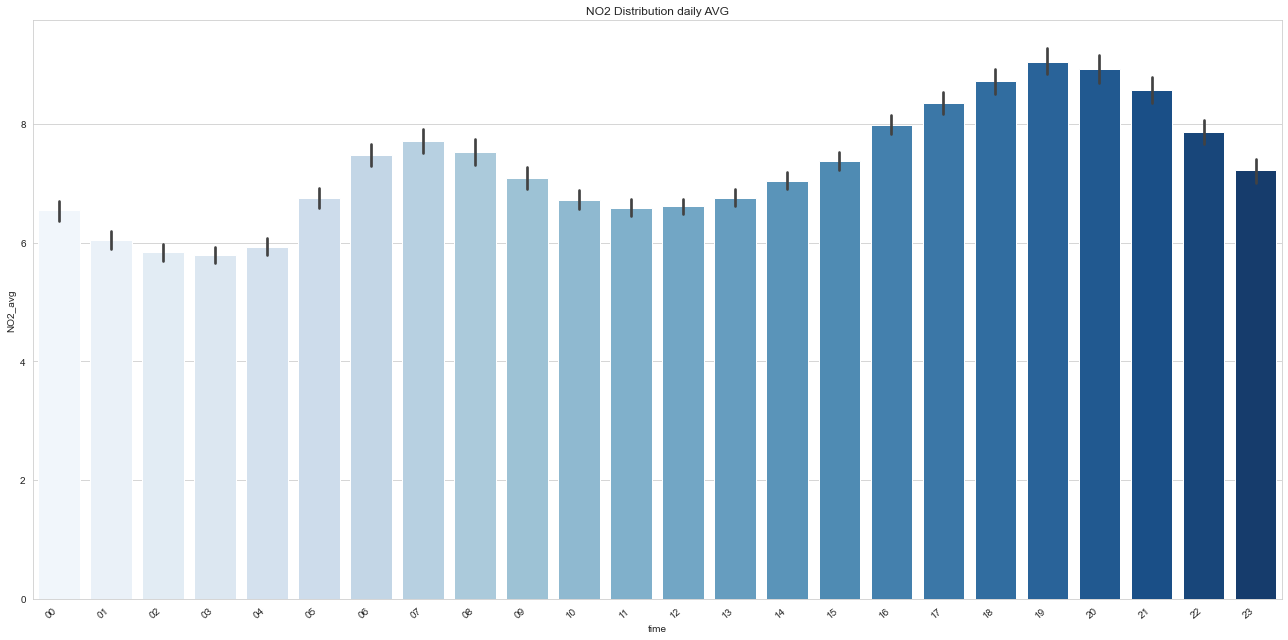

In [24]:
query = """
SELECT *, AVG(NO2) as NO2_avg, AVG(O3) as O3_avg, AVG(PM10) as PM10_avg, AVG("PM2.5") as "PM2.5_avg"
FROM df 
WHERE station = "Ulm in der Wanne"
GROUP BY station, date, time
ORDER BY time ASC
"""
data = sqldf(query, globals())

sns.set_style('whitegrid')
plt.figure(figsize=(18,9))
plot = sns.barplot(data=data, x='time', y='NO2_avg', palette='Blues')
plot.set_xticklabels(plot.get_xticklabels(), rotation=40, ha="right")
plot.set(title='NO2 Distribution daily AVG')
plt.tight_layout()
plt.show()

2. Gibt es Unterschiede in den Messverläufen je nach Tageszeit?

3. Wie entwickeln sich diese Werte über die Zeit?

4. Kann mit Hilfe eines ML Algorithmus bestimmt werden, ob diese Werte mit der Zeit steigen oder fallen?

5. Verteilung über Monat / Jahr